# Оглавление

- [Описание проекта](#step1)
- [Описание данных](#step2)
- [Открытие файла с данными и изучение общей информации](#step3)
- [Подготовка данных](#step4)
- [Изучение и проверка данных](#step5)
- [Изучение воронки событий](#step6)
- [Изучение результатов эксперимента](#step7)
- [Выводы](#step8)

# Описание проекта <a id="step1"></a>

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

# Описание данных <a id="step2"></a>

Каждая запись в логе — это действие пользователя, или событие.

- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

# Открытие файла с данными и изучение общей информации <a id="step3"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math as mth
from plotly import graph_objects as go
from scipy import stats as st

logs = pd.read_csv('/datasets/logs_exp.csv', sep="\t")
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


# Подготовка данных <a id="step4"></a>

In [2]:
logs.columns = ['event_name', 'user_id', 'event_time', 'group']

In [3]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   user_id     244126 non-null  int64 
 2   event_time  244126 non-null  int64 
 3   group       244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
logs = logs.drop_duplicates()

В данных присутствуют дубликаты, поэтому принято решение их сразу удалить

In [5]:
logs['event_time'] = pd.to_datetime(logs['event_time'], unit='s')
logs['date'] = logs['event_time'].dt.date
logs.head()

,event_name,user_id,event_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [6]:
def rename_group(i):
    if i==246:
        return 'a1'
    elif i==247:
        return 'a2'
    elif i==248:
        return 'b'

logs['group'] = logs['group'].apply(rename_group)
logs

,event_name,user_id,event_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,a1,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,a1,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,b,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,b,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,b,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,a2,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,a1,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,a1,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,a1,2019-08-07


In [7]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group       243713 non-null  object        
 4   date        243713 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 11.2+ MB


1. Изменили тип данных event_time на datetime
2. Добавили дополнительный столбец отражающий только дату

#### Выводы: 
На данном этапе исправил названия столбцов на более удобные для себя. Также удалил полные дубликаты. Изменил тип данных event_time на временной и добавил столбец, который отражает только дату. На этом этапе завершаем подготовку данных

# Изучение и проверка данных <a id="step5"></a>

#### Сколько всего событий в логе? Сколько всего пользователей в логе? Сколько в среднем событий приходится на пользователя? Данными за какой период вы располагаете? Найдите максимальную и минимальную дату.

In [8]:
events = len(logs)
device_id = logs['user_id'].nunique()

print('Всего событий: {}'.format(events))
print('Всего пользователей: {}'.format(device_id))
print('Событий на пользователя в среднем: {}'.format(int(round(events/device_id, 0))))
print('Минимальная дата: {}. Максимальная дата: {}'.format(logs['date'].min(), logs['date'].max()))

Всего событий: 243713
Всего пользователей: 7551
Событий на пользователя в среднем: 32
Минимальная дата: 2019-07-25. Максимальная дата: 2019-08-07


#### Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период?

,user_id
date,
2019-07-25,9
2019-07-26,31
2019-07-27,55
2019-07-28,105
2019-07-29,184
2019-07-30,412
2019-07-31,2030
2019-08-01,36141
2019-08-02,35554


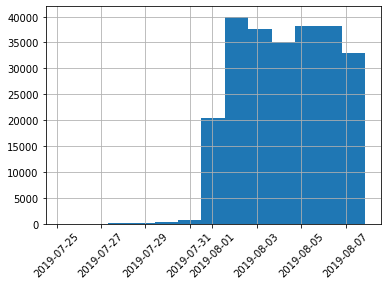

In [9]:
plt.xticks(rotation=45)
logs['event_time'].hist(bins=13)

logs.groupby('date').agg({'user_id':'count'})

Данные не полные за весь период. Видим, что на графике резкий прирост данных с 1 августа. Данные до 1 августа придется удалить, потому что их слишком мало и на их основе тяжело делать правильные выводы в будущем

In [10]:
logs_filtered = logs[logs['date'] >= pd.to_datetime('2019-08-01', format = '%Y-%m-%d')]

events_filtered = len(logs_filtered)
device_id_filtered = logs_filtered['user_id'].nunique()

logs_filtered.head()

,event_name,user_id,event_time,group,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,a1,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,a1,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,a1,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,a1,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,a2,2019-08-01


#### Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [11]:
print('Всего событий: {}'.format(events))
print('Всего событий после фильтрации: {}'.format(events_filtered))
print('Всего пользователей: {}'.format(device_id))
print('Всего пользователей после фильтрации: {}'.format(device_id_filtered))

Всего событий: 243713
Всего событий после фильтрации: 240887
Всего пользователей: 7551
Всего пользователей после фильтрации: 7534


In [12]:
round(events_filtered/events*100 - 100, 2)

-1.16

In [13]:
round(device_id_filtered/device_id*100 - 100, 2)

-0.23

Совсем незначительное снижение в событиях и пользователях

#### Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп

In [14]:
exp_groups = logs_filtered.groupby('group', as_index=False).agg({'user_id':'count'})
exp_groups.columns = ['экспериментальная группа', 'количество пользователей']
exp_groups

,экспериментальная группа,количество пользователей
0,a1,79302
1,a2,77022
2,b,84563


Есть пользователи из всех трёх экспериментальных групп

#### Выводы:
1. Всего событий: 243 713. Всего пользователей: 7551
2. Полные данные доступны после 31 июля. Принято решение удалить данные до 1 августа
3. После удаления данных количество событий и пользователей поменялось совсем незначительно (-1.16% и -0.23% соответственно)
4. Пользователи присутствуют во всех трех эксперементальных группах

# Изучение воронки событий <a id="step6"></a>

#### Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [34]:
logs_kind = logs_filtered.groupby('event_name', as_index=False).agg({'user_id':'count'})
logs_kind.columns = ['название события', 'количество пользователей']
logs_kind_funnel = logs_kind['количество пользователей'].sort_values(ascending=False).to_list()
fig = go.Figure(
    go.Funnel(
        y=[
            'Главная страница',
            'Экран предложений',
            'Корзина',
            'Успешная оплата',
            'Руководство'
        ],
        x=logs_kind_funnel,
    )
)
fig.show()

In [37]:
logs_kind_funnel

[117328, 46333, 42303, 33918, 1005]

1. Видим, что воронка сильно сужается в моменте перехода из главного экрана в экран предложений. Частая проблема многих мобильных приложений, что пользователи "ленятся" переходить дальше главного экрана. 
2. Второе узкое горлышко - руководство. Тяжело сказать, что находится на этой странице. Сделаю предположение, что там показывают варианты использования продуктов. Есть ощущение, что этот экран вообще никому не нужен. Человек достиг своей цели, а именно успешно оплатил продукты питания. Зачем ему руководство? Может удалить этот экран? Продукты питания не настолько сложный продукт, которому нужно какое-то руководство :)

#### Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [16]:
logs_kind = logs_filtered.groupby('event_name', as_index=False).agg({'user_id':'nunique'})
logs_kind.columns = ['название события', 'количество пользователей']
logs_kind_funnel = logs_kind['количество пользователей'].sort_values(ascending=False).to_list()
fig = go.Figure(
    go.Funnel(
        y=[
            'Главная страница',
            'Экран предложений',
            'Корзина',
            'Успешная оплата',
            'Руководство'
        ],
        x=logs_kind_funnel,
    )
)
fig.show()

В пользователях картина чуть лучше. Гораздо сильно уменьшился разрыв между первой и второй воронкой (увеличились примерно на ~20% пунктов). Однако ситуация с "Руководство" хоть и стала лучше, проблема всё ещё явной. Снова встаёт вопрос: нам точно нужен туториал? Он вообще не влияет на процесс покупки. Кажется это лишний этап.

#### Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

Возьмем для примера любой один user_id, чтобы посмотреть на хронологию событий

In [17]:
logs_filtered[logs_filtered['user_id'] == 3737462046622621720].sort_values(by='event_time')

,event_name,user_id,event_time,group,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,a1,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,a1,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,a1,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,a1,2019-08-01
2834,OffersScreenAppear,3737462046622621720,2019-08-01 00:10:26,a1,2019-08-01
2835,MainScreenAppear,3737462046622621720,2019-08-01 00:10:47,a1,2019-08-01
2836,MainScreenAppear,3737462046622621720,2019-08-01 00:11:10,a1,2019-08-01
2837,MainScreenAppear,3737462046622621720,2019-08-01 00:11:20,a1,2019-08-01
2841,Tutorial,3737462046622621720,2019-08-01 00:12:18,a1,2019-08-01
2842,MainScreenAppear,3737462046622621720,2019-08-01 00:12:34,a1,2019-08-01


Выяснили, что оказывается экран "Руководство" необязательно находится на последнем этапе воронки. Возможно, это онбордиг + кнопка на главном экране при нажатии на которую происходит переход на руководство по использованию приложения или покупке товаров. Также по этим данным можно понять, что экран оплаты и экран предложений необязательно должен идти до экрана корзины (2019-08-03 14:22:49). То есть, фактически можно оплатить товар прямо с главного экрана (возможно до этого пользователь на экране предложений добавил товары в корзину, потом перешел на главную, где снизу появилась всплывающая кнопка о покупке товара)

#### По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.


Берём данные из двух верних интерактивных воронок (при наведении):
1. Воронка в событиях:
    - Из "Главный экран" в "Экран предложений": 39.5%
    - Из "Экран предложений" в "Корзина": 91.3%
    - Из "Корзина" в "Успешная оплата": 80.2%
    - Из "Успешная оплата" в "Руководство": 3%
2. Воронка в пользователях:
    - Из "Главный экран" в "Экран предложений": 61.9%
    - Из "Экран предложений" в "Корзина": 81.3%
    - Из "Корзина" в "Успешная оплата": 94.8%
    - Из "Успешная оплата" в "Руководство": 23.7%

#### На каком шаге теряете больше всего пользователей?

1. Воронка в событиях:
    - Больше всего пользователей теряется при переходе из "Главный экран" в "Экран предложений": 60.5%
    - Не буду оценивать переход из "Успешная оплата" в "Руководство", так как экран "Руководство" скорее всего является экраном онбордингом, который явно нельзя встраивать в последний шаг



2. Воронка в пользователях:
    - Больше всего пользователей теряется при переходе из "Главный экран" в "Экран предложений": 38.1%

#### Какая доля пользователей доходит от первого события до оплаты?

Берём данные из двух верних интерактивных воронок (при наведении):

1. Воронка в событиях:
    - Из "Главный экран" в "Успешная оплата": 28.9%
2. Воронка в пользователях:
    - Из "Главный экран" в "Успешная оплата": 47.7%

#### Выводы:
1. Следующие события встречаются в логах (в таком порядке по частоте: от большего к меньшему): главный экран, экран предложений, корзина, успешная оплата, руководство
2. На второй этап в пользователях попадает лишь 61.9%  пользователей. Нужно выяснить причину (возможно исследовать интерфейс или провести качественное исследование с помощью опросов или фокус-группы). Но по моему опыту достаточно большое количество пользователей отваливается на главном экране
3. В целом события идут одна вслед за другой, за исключием "Руководства". Событие неважное, можно его игнорировать при изучении результатов эксперимента
4. Из главного экрана в успешную оплату конвертируется чуть меньше половины пользователей (47.7%)

# Изучение результатов эксперимента <a id="step7"></a>

#### Сколько пользователей в каждой экспериментальной группе?

In [18]:
users_by_group = logs.groupby('group')['user_id'].nunique()
users_by_group['a'] = users_by_group['a1'] + users_by_group['a2']
users_by_group

group
a1    2489
a2    2520
b     2542
a     5009
Name: user_id, dtype: int64

#### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

Группы разбиты довольно равномерно. Разница между А1/А2 группами равна ~1.15%. Разница А2 с В равна ~0.94%

In [19]:
a1 = logs_filtered[logs_filtered['group'] == 'a1']['user_id'].unique()
a2 = logs_filtered[logs_filtered['group'] == 'a2']['user_id'].unique()
b = logs_filtered[logs_filtered['group'] == 'b']['user_id'].unique()

In [20]:
a1_b = []
a2_b = []
a1_a2 = []

for i in a1:
    if i in b:
        a1_b.append(i)
    if i in a2:
        a1_a2.append(i)
        
for i in b:
    if i in a2:
        a2_b.append(i)
        
print(a1_b)
print(a2_b)
print(a1_a2)

[]
[]
[]


Пересечения отсутствуют

In [21]:
#код ревьюера
#можно сделать проще
sum(logs_filtered.groupby('user_id')['group'].nunique()!=1)


0

#### Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

In [22]:
logs['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Самое популярное событие просмотр главной страницы

In [23]:
test_group = (logs[logs['event_name']!='Tutorial']
              .pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique'))

test_group = test_group.reset_index()
test_group.columns = ['event', 'a1', 'a2', 'b']
test_group['all'] = test_group['a1'] + test_group['a2'] + test_group['b']
test_group['a'] = test_group['a1'] + test_group['a2']

test_group['a1, %'] = round(test_group['a1'] / users_by_group['a1'] * 100, 2)
test_group['a2, %'] = round(test_group['a2'] / users_by_group['a2'] * 100, 2)
test_group['b, %'] = round(test_group['b'] / users_by_group['b'] * 100, 2)
test_group['a, %'] = round((test_group['a1'] + test_group['a2']) / (users_by_group['a1'] + users_by_group['a2']) * 100, 2)

test_group = test_group.sort_values(by='all', ascending=False).reset_index(drop=True)
test_group

,event,a1,a2,b,all,a,"a1, %","a2, %","b, %","a, %"
0,MainScreenAppear,2456,2482,2501,7439,4938,98.67,98.49,98.39,98.58
1,OffersScreenAppear,1545,1530,1538,4613,3075,62.07,60.71,60.50,61.39
2,CartScreenAppear,1270,1240,1239,3749,2510,51.02,49.21,48.74,50.11
3,PaymentScreenSuccessful,1202,1160,1185,3547,2362,48.29,46.03,46.62,47.16


Число пользователей совершивших самое популярное событие:
- а1 = 2456
- а2 = 2482
- b = 2501

Доля пользователей совершивших самое популярное событие по группам:

- а1 = 98.67%
- а2 = 98.49%
- b = 98.39%

Нулевая гипотеза: Нет значимой разницы между долями групп
Альтернативная гипотеза: Между долями групп существует значимая разница

In [24]:
def z_test(group_1, group_2, alpha):
    for i in test_group.index:
        p1 = test_group[group_1][i] / users_by_group[group_1]

        p2 = test_group[group_2][i] / users_by_group[group_2]

        p_combined = ((test_group[group_1][i] + test_group[group_2][i]) / 
                      (users_by_group[group_1] + users_by_group[group_2]))

        difference = p1 - p2

        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users_by_group[group_1] + 1/users_by_group[group_2]))

        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(test_group['event'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print()
        
z_test("a1", "a2", 0.01)

MainScreenAppear p-значение: 0.5856639791209877
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.3233225048227193
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.19817540651836918
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.10902546202332886
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



#### Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?


a1/b

In [25]:
z_test("a1", "b", 0.05)

MainScreenAppear p-значение: 0.39774960182882513
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.2531656758489338
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.10534150642722295
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.23403912852637143
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



a2/b

In [26]:
z_test("a2", "b", 0.05)

MainScreenAppear p-значение: 0.7632160970326178
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.878057445632423
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.7406094633808076
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6763830984465451
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



a/b

In [27]:
z_test("a", "b", 0.05)

MainScreenAppear p-значение: 0.5067126962216841
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.4555404043137232
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.2609811882648243
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6578429353593096
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Вывод: Значимая разница во всех группах по пропорциям отсутствует

#### Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

- В ходе теста было проведено 16 проверок статистических гипотез:
    - А1/А2 тест: 1%
    - Остальное: 5%
- Для А/А теста выбрал стат.значимость 1%, так как контроль разницы между контрольными группами должен быть жестче
- Уровень значимости 10% слишком велик, возьмем стандарто принимаю величину стат.значимости

In [28]:
#код ревьюера
#вероятность появления ошибки при N тестах без поправки
alpha = 0.05
counts_test=12
probability_of_error=1-(1-alpha)**counts_test

print('Вероятность появления ошибки при N тестах без поправки: {:.2%}'.format(probability_of_error))

Вероятность появления ошибки при N тестах без поправки: 45.96%


In [29]:
#код ревьюера
#вероятность появления ошибки при N тестах с учетом поправки
alpha = 0.05
counts_test=12
alpha_bonferroni =alpha/counts_test

probability_of_error=1-(1-alpha_bonferroni)**counts_test

print('Вероятность появления ошибки при N тестах с учетом поправки: {:.2%}'.format(probability_of_error))

Вероятность появления ошибки при N тестах с учетом поправки: 4.89%


# Выводы <a id="step8"></a>

1. Изучение данных:
    - Всего событий: 243 713. Всего пользователей: 7551
    - Полные данные доступны после 31 июля. Принято решение удалить данные до 1 августа
    - После удаления данных количество событий и пользователей поменялось совсем незначительно (-1.16% и -0.23% соответственно)
    - Пользователи присутствуют во всех трех эксперементальных группах
2. Изучение воронки продаж:
    - Следующие события встречаются в логах (в таком порядке по частоте: от большего к меньшему): главный экран, экран предложений, корзина, успешная оплата, руководство
    - На второй этап в пользователях попадает лишь 61.9% пользователей. Но по моему опыту достаточно большое количество пользователей отваливается на главном экране
    - В целом события идут одна вслед за другой, за исключием "Руководства". Событие неважное, можно его игнорировать при изучении результатов эксперимента
    - Из главного экрана в успешную оплату конвертируется чуть меньше половины пользователей (47.7%)
3. Изучение результатов эксперимента:
    - Было проверено 16 статистических гипотез:
        - А1/А2 тест: 1%
        - Остальное: 5%
    - В результате проведения исследований никаких стат.значимых результатов в пропорциях не наблюдалось
    - Для А/А теста выбрали 1% стат.значимость, так как контроль между контрольными группами требуется более жесткий